In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Root directory to hdd
DATA_DIR = os.path.abspath("/data/hdd")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import mrcnn.model as modellib
from mrcnn import data_generator
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.load_weights import load_weights

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATA_DIR, "russales", "test_logs")

# Local path to trained weights file
JUMP_MODEL_PATH = os.path.join(DATA_DIR, "russales", "logs", "jump20190413T1600", "mask_rcnn_jump_0003.h5")

Using TensorFlow backend.


In [2]:
# MS COCO Dataset
import jump
class InferenceConfig(jump.JumpConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
#    TRAINING_HEADS = "keypoint"

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_LOSS_WEIGHTING        True
KEYPOINT_MASK_POOL_SIZE        14
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'mrcnn_keypoint_loss': 1.0, 

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
GPU_ID = "0"
DEVICE = "/gpu:{}".format(GPU_ID)  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Dataset

In [5]:
# Validation dataset
JUMP_DIR = os.path.join(DATA_DIR, "russales", "JumpDataset", "mscoco_format")
dataset = jump.JumpDataset()
dataset.load_jump(JUMP_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Skeleton: (0,)
Keypoint names: (20,)
Images: 219
Classes: ['BG', 'person']


## Load Model

In [6]:
# Create model in inference mode
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, config=config, model_dir=MODEL_DIR)

# Load weights
print("Loading weights ", JUMP_MODEL_PATH)
load_weights(model, JUMP_MODEL_PATH, by_name=True, include_optimizer=False)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  /data/hdd/russales/logs/jump20190413T1600/mask_rcnn_jump_0003.h5
Re-starting from epoch 3


## Run Detection

In [7]:
# load image and ground truth data
dg = data_generator.DataGenerator(dataset, config, shuffle=True, batch_size=config.BATCH_SIZE)

#image_id = random.choice(dataset.image_ids)
image_id = 6

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

from mrcnn import augmenter
augmentation = augmenter.FliplrKeypoint(1, config=config, dataset=dataset)

image, image_meta, gt_class_ids, gt_boxes, gt_masks, gt_keypoints = \
    dg.load_image_gt(image_id, augmentation=None, use_mini_mask=False)

print(gt_masks)

image ID: jump.2825 (6) 
checking if directory : /data/hdd/russales/JumpDataset/Segmentation_masks/annotierte_daten_springer/drei 010117 Moellers 3_(0198) exists
3
4
3
4


RuntimeError: sequence argument must have length equal to input rank


*** No instances to display *** 



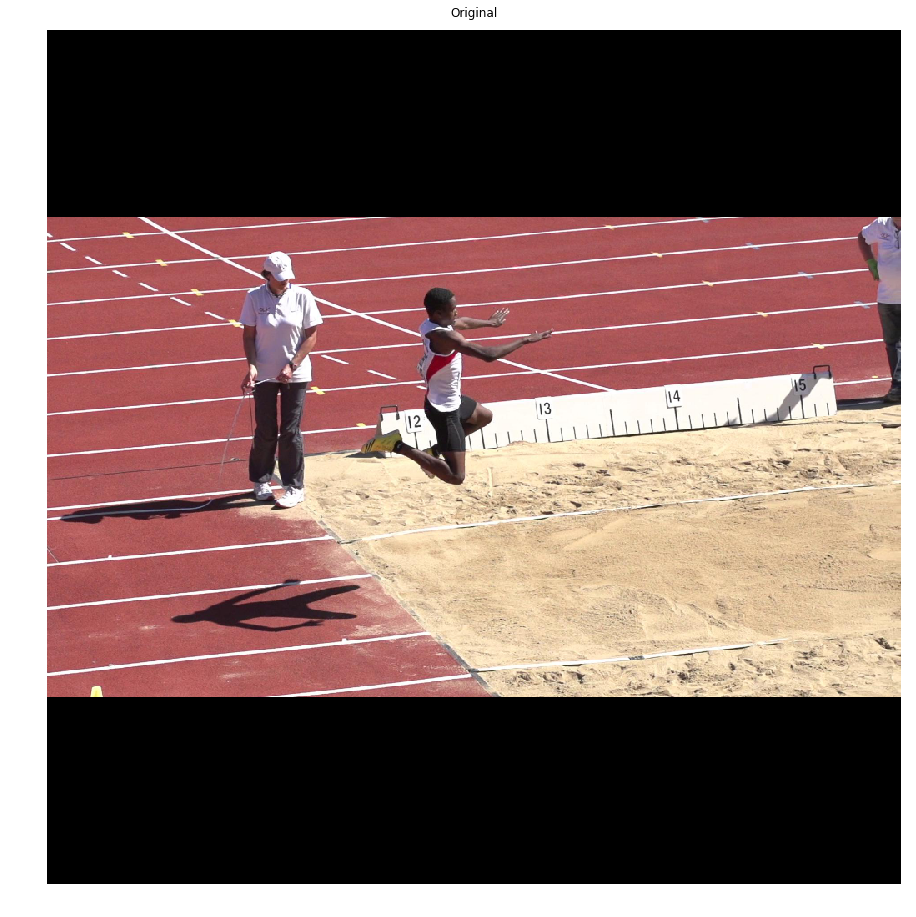

In [8]:
ax = get_ax(1)
#visualize.display_keypoints(image, gt_boxes, gt_keypoints, gt_class_ids, dataset.class_names,
#                            ax=ax, title="Original", dataset=dataset)

visualize.display_instances(image, gt_boxes, gt_masks, gt_class_ids, 
                            dataset.class_names, ax=ax, title="Original")

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
windows                  shape: (1, 4)                min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
------ Predictions ----------
detections               shape: (1, 50, 6)            min:    0.00000  max:    1.00000  float32
mrcnn_class              shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
mrcnn_bbox               shape: (1, 1000, 2, 4)       min:   -3.21410  max:    3.21275  float32
rois                     shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  floa

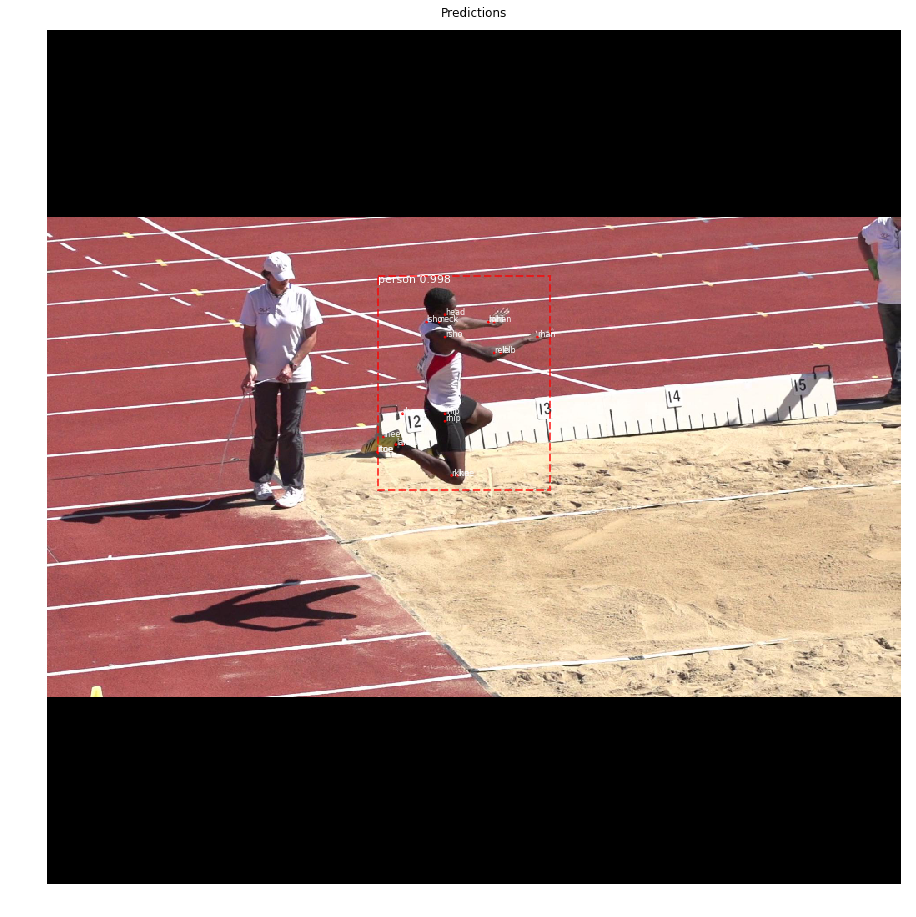

In [21]:
# Run object detection for keypoints
results = model.detect_keypoint([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

bboxes_result = r['bboxes']
class_ids_result = r['class_ids']
scores_result = r['scores']
keypoints_result = r['keypoints']

visualize.display_keypoints(image, bboxes_result, keypoints_result, class_ids_result, dataset.class_names,
                         scores=scores_result , ax=ax, title="Predictions", dataset=dataset)